# <b><span style='color:#F1A424'>|</span> HMS: <span style='color:#F1A424'>Harmful Brain Activity Classification</span><span style='color:#ABABAB'> [Train]</span></b> 

***

**Consider upvoting this notebook if you find it useful 🙌🏼**

- [Inference Notebook](https://www.kaggle.com/alejopaullier/hms-efficientnetb0-pytorch-inference)
- In case you don't want to train the model you can find my dataset with [5-fold trained Efficientnet models](https://www.kaggle.com/datasets/alejopaullier/hms-efficientnetb0-5-folds) that are the result of running this notebook.

This is the **PyTorch 🔥 version** of [Chris Deotte EfficientNetB0 Starter](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43#Train-DataLoader) give him an upvote too ⬆️!

Your goal in this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

In this notebook you will learn how to train a `efficientnet` model for image classification using PyTorch. Hope you enjoy it and find it useful.

### <b><span style='color:#F1A424'>Table of Contents</span></b> <a class='anchor' id='top'></a>
<div style=" background-color:#3b3745; padding: 13px 13px; border-radius: 8px; color: white">
<li> <a href="#introduction">Introduction</a></li>
<li> <a href="#install_libraries">Install libraries</a></li>
<li><a href="#import_libraries">Import Libraries</a></li>
<li><a href="#configuration">Configuration</a></li>
<li><a href="#utils">Utils</a></li>
<li><a href="#load_data">Load Data</a></li>
<li><a href="#preprocessing">Data Pre-processing</a></li>
<li><a href="#validation">Validation</a></li>
<li><a href="#dataset">Dataset</a></li>
<li><a href="#dataloader">DataLoader</a></li>
<li><a href="#model">Model</a></li>
<li><a href="#scheduler">Scheduler</a></li>
<li><a href="#loss">Loss Function</a></li>
<li><a href="#functions">Train and Validation Functions</a></li>
<li><a href="#train_loop">Train Loop</a></li>
<li><a href="#train_full">Full Train</a></li>
<li><a href="#train">Train</a></li>
</div>


# <b><span style='color:#F1A424'>|</span> Introduction</b><a class='anchor' id='introduction'></a> [↑](#top) 

***

### <b><span style='color:#F1A424'>What is an EEG waveform?</span></b>

**EEG** (Electroencephalogram) waveforms are the **patterns of electrical activity generated by the brain**, which are recorded using electrodes placed on the scalp. EEG is a non-invasive method that measures the electrical potentials produced by the firing of neurons in the brain. These electrical potentials are then amplified and displayed as waveforms on a computer or paper.

- **Delta Waves (0.5-4 Hz):** Delta waves are slow-wave patterns associated with deep sleep and certain abnormal brain states. They are usually the dominant waves during deep sleep stages.
- **Theta Waves (4-8 Hz):** Theta waves are associated with drowsiness, relaxation, and the early stages of sleep. They can also be present during deep meditation.
- **Alpha Waves (8-13 Hz):** Alpha waves are dominant when a person is awake but relaxed and not actively processing information. They are commonly seen when a person's eyes are closed.
- **Beta Waves (13-30 Hz):** Beta waves are associated with active, alert, and focused mental activity. They are commonly observed when a person is awake and engaged in cognitive tasks.
- **Gamma Waves (30-100 Hz and above):** Gamma waves are associated with higher cognitive functions, such as perception, learning, and problem-solving. They are not always present and are often associated with specific cognitive tasks.

In this competition, EEG waveforms are 50 seconds long.

### <b><span style='color:#F1A424'>What is a spectogram?</span></b>

A spectrogram is a visual representation of the spectrum of frequencies in a signal as they vary with time. It is a three-dimensional plot that displays how the frequencies of a signal change over time. Spectrograms are commonly used in signal processing, audio analysis, and other fields to analyze the frequency content of a signal and how it evolves over time.

### <b><span style='color:#F1A424'>Useful References</span></b>

- [Understand this competition's data](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010)


# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top) 

***

Import all the required libraries for this notebook.

In [1]:
import albumentations as A
import gc
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import timm
import torch
import torch.nn as nn


from albumentations.pytorch import ToTensorV2
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List
#from sklearn import GridSearchCV


# Graph
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
sns.set_theme()

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using 2 GPU(s)


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

In [2]:
class config:
    AMP = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 32
    EPOCHS = 4
    FOLDS = 5
    FREEZE = False
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e7
    MODEL = "tf_efficientnet_b0"
    NUM_FROZEN_LAYERS = 39
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01
    
    
class paths:
    OUTPUT_DIR = "/kaggle/working/"
    PRE_LOADED_EEGS = '/kaggle/input/brain-eeg-spectrograms/eeg_specs.npy'
    PRE_LOADED_SPECTOGRAMS = '/kaggle/input/brain-spectrograms/specs.npy'
    TRAIN_CSV = "/kaggle/input/hms-harmful-brain-activity-classification/train.csv"
    TRAIN_EEGS = "/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/"
    TRAIN_SPECTOGRAMS = "/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/"

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions.

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectogram recordings from a parquet file.
    :param spectrogram_path: path to the spectogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    

target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load the competition's data.

In [4]:
df = pd.read_csv(paths.TRAIN_CSV)
label_cols = df.columns[-6:]
print(f"Train dataframe shape is: {df.shape}")
print(f"Labels: {list(label_cols)}")
df.head()

Train dataframe shape is: (106800, 15)
Labels: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
df["spectrogram_id"].nunique()

11138

In [6]:
df["eeg_id"].nunique()

17089

In [7]:
df['eeg_id'].value_counts()

eeg_id
2259539799    743
2428433259    664
1641054670    562
2860052642    534
525664301     531
             ... 
3115575521      1
3218602720      1
3851517872      1
3042198969      1
3009745953      1
Name: count, Length: 17089, dtype: int64

In [8]:
df['patient_id'].value_counts()

patient_id
30631    2215
2641     2185
35627    1403
28330    1362
54199    1350
         ... 
35789       1
47074       1
33821       1
16282       1
46428       1
Name: count, Length: 1950, dtype: int64

In [9]:
df['expert_consensus'].value_counts()

expert_consensus
Seizure    20933
GRDA       18861
Other      18808
GPD        16702
LRDA       16640
LPD        14856
Name: count, dtype: int64

In [10]:
df['patient_id'].value_counts()

patient_id
30631    2215
2641     2185
35627    1403
28330    1362
54199    1350
         ... 
35789       1
47074       1
33821       1
16282       1
46428       1
Name: count, Length: 1950, dtype: int64

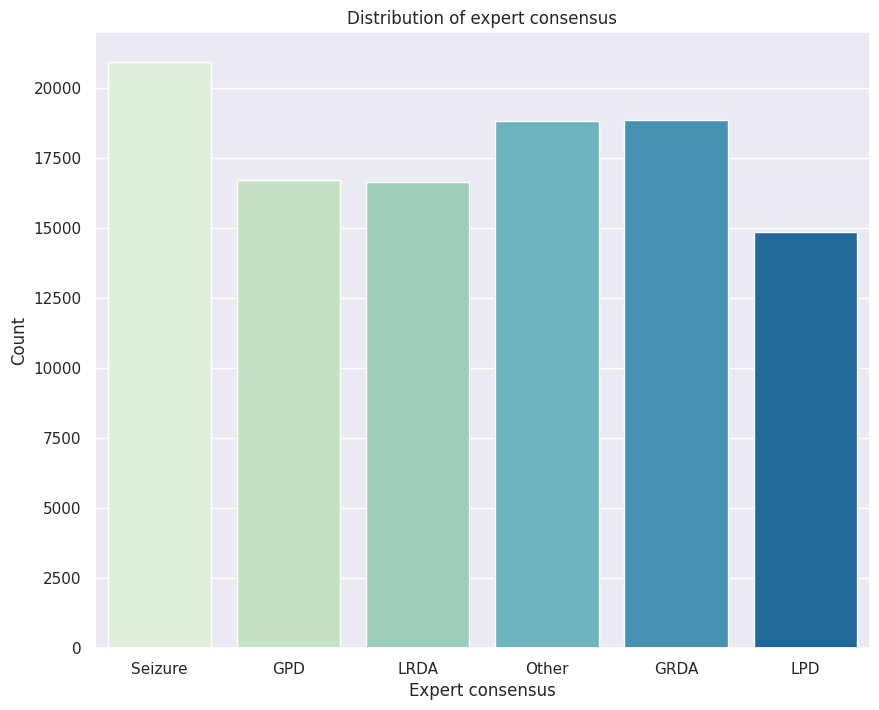

In [11]:

plt.figure(figsize=(10,8))
sns.countplot(df, x="expert_consensus",palette="GnBu")
plt.title("Distribution of expert consensus")
plt.xlabel("Expert consensus")
plt.ylabel("Count")
plt.show()

# <b><span style='color:#F1A424'>|</span> Data pre-processing</b><a class='anchor' id='pre_processing'></a> [↑](#top) 

***

### <b><span style='color:#F1A424'>Create Non-Overlapping Eeg Id Train Data</span></b>

The competition data description says that test data does not have multiple crops from the same `eeg_id`. Therefore we will train and validate using only 1 crop per `eeg_id`. There is a discussion about this [here][1].

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [12]:
# grouping by eeg_id and selecting minimum value of spectrogram_label_offset_seconds (mostly 0.0) 
train_df = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_id':'first',
    'spectrogram_label_offset_seconds':'min'
})
train_df.columns = ['spectogram_id','min']

# group again and select max value of spectrogram_label_offset_seconds
aux = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_label_offset_seconds':'max'
})
train_df['max'] = aux

# extract first patient id for each eeg
aux = df.groupby('eeg_id')[['patient_id']].agg('first')
train_df['patient_id'] = aux

# taking average prediction for each label
aux = df.groupby('eeg_id')[label_cols].agg('sum')
for label in label_cols:
    train_df[label] = aux[label].values
    
y_data = train_df[label_cols].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_df[label_cols] = y_data

# extract expert consensus value --> target value
aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train_df['target'] = aux

train_df = train_df.reset_index()
print('Train non-overlapp eeg_id shape:', train_df.shape )
train_df.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spectogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [13]:
# calculating the expert consensus prediction distribution
train_df['target'].value_counts()/sum(train_df['target'].value_counts())
    

target
Other      0.421090
Seizure    0.162970
LPD        0.150799
GRDA       0.106969
GPD        0.104570
LRDA       0.053602
Name: count, dtype: float64

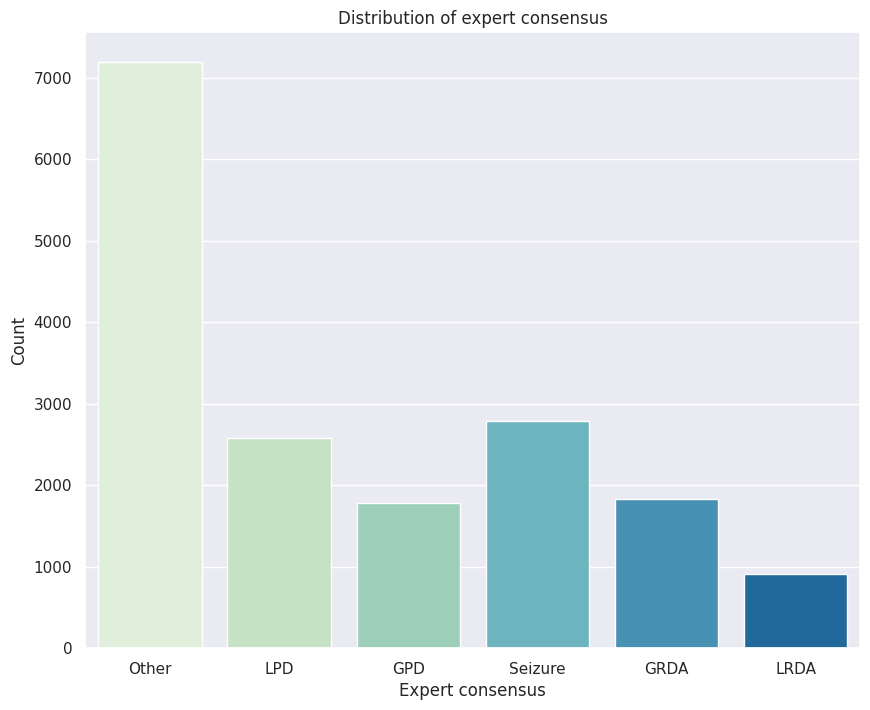

In [14]:


plt.figure(figsize=(10,8))
sns.countplot(train_df, x="target",palette="GnBu")
plt.title("Distribution of expert consensus")
plt.xlabel("Expert consensus")
plt.ylabel("Count")
plt.show()

In [15]:
class CFG:
    dataset_path="/kaggle/input/hms-harmful-brain-activity-classification"
    targets=['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    seed = 42

CFG = CFG()



<Figure size 1200x800 with 0 Axes>

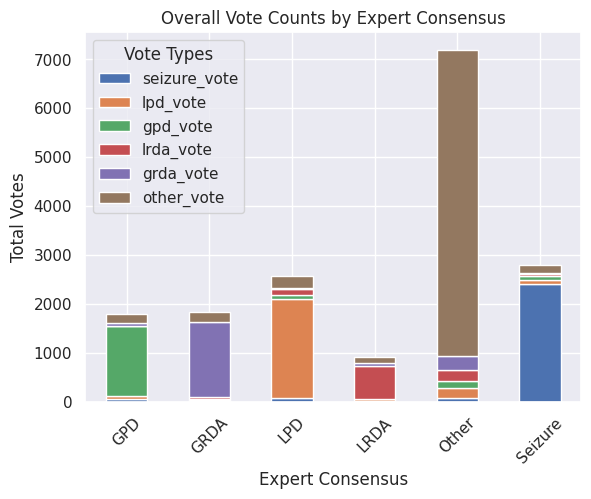

In [16]:
vote_counts_by_consensus = train_df.groupby('target')[CFG.targets].sum()

plt.figure(figsize=(12, 8))
vote_counts_by_consensus.plot(kind='bar', stacked=True)
plt.title('Overall Vote Counts by Expert Consensus')
plt.xlabel('Expert Consensus')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.legend(title='Vote Types')
plt.show()


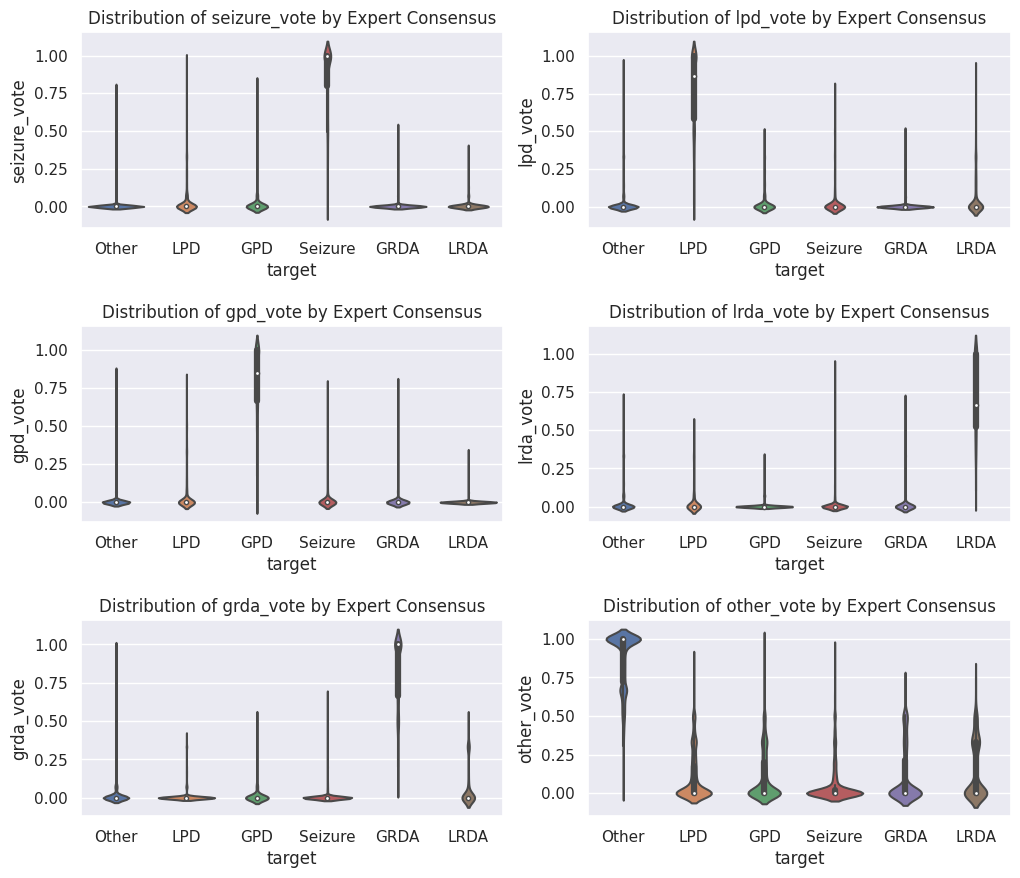

In [17]:

plt.figure(figsize=(12,14))
for i, column in enumerate(CFG.targets,1):
    plt.subplot(4, 2, i)
    plt.subplots_adjust(hspace=0.5)
    sns.violinplot(data=train_df, x='target', y=column)
    plt.title(f'Distribution of {column} by Expert Consensus')
plt.show()


In [18]:
# is there a way to open a specific eeg (with its id) to see its picture?

### <b><span style='color:#F1A424'>Read Train Spectrograms</span></b>


First we need to read in all 11k train spectrogram files. Reading thousands of files takes 11 minutes with Pandas. Instead, we can read 1 file from my [Kaggle dataset here][1] which contains all the 11k spectrograms in less than 1 minute! To use my Kaggle dataset, set variable `READ_SPEC_FILES = False`. Thank you for upvoting my helpful [dataset][1] :-)

The resulting `all_spectograms` dictionary contains `spectogram_id` as keys (`int` keys) and the values are the spectogram sequences (as 2-dimensional `np.array`) of shape `(timesteps, 400)`.

Each spectogram is a parquet file. This parquet, when converted to a pandas dataframe, results in a dataframe of shape `(time_steps, 401)`. First column is the `time` column and the remaining 400 columns are the recordings. There are 400 columns because there are, respectively, 100 rows associated to the 4 recording regions of the EEG electrodes: `LL`, `RL`, `LP`, `RP`. Column names also include the frequency in heartz.

[1]: https://www.kaggle.com/datasets/cdeotte/brain-spectrograms

There are 11138 spectrogram parquets


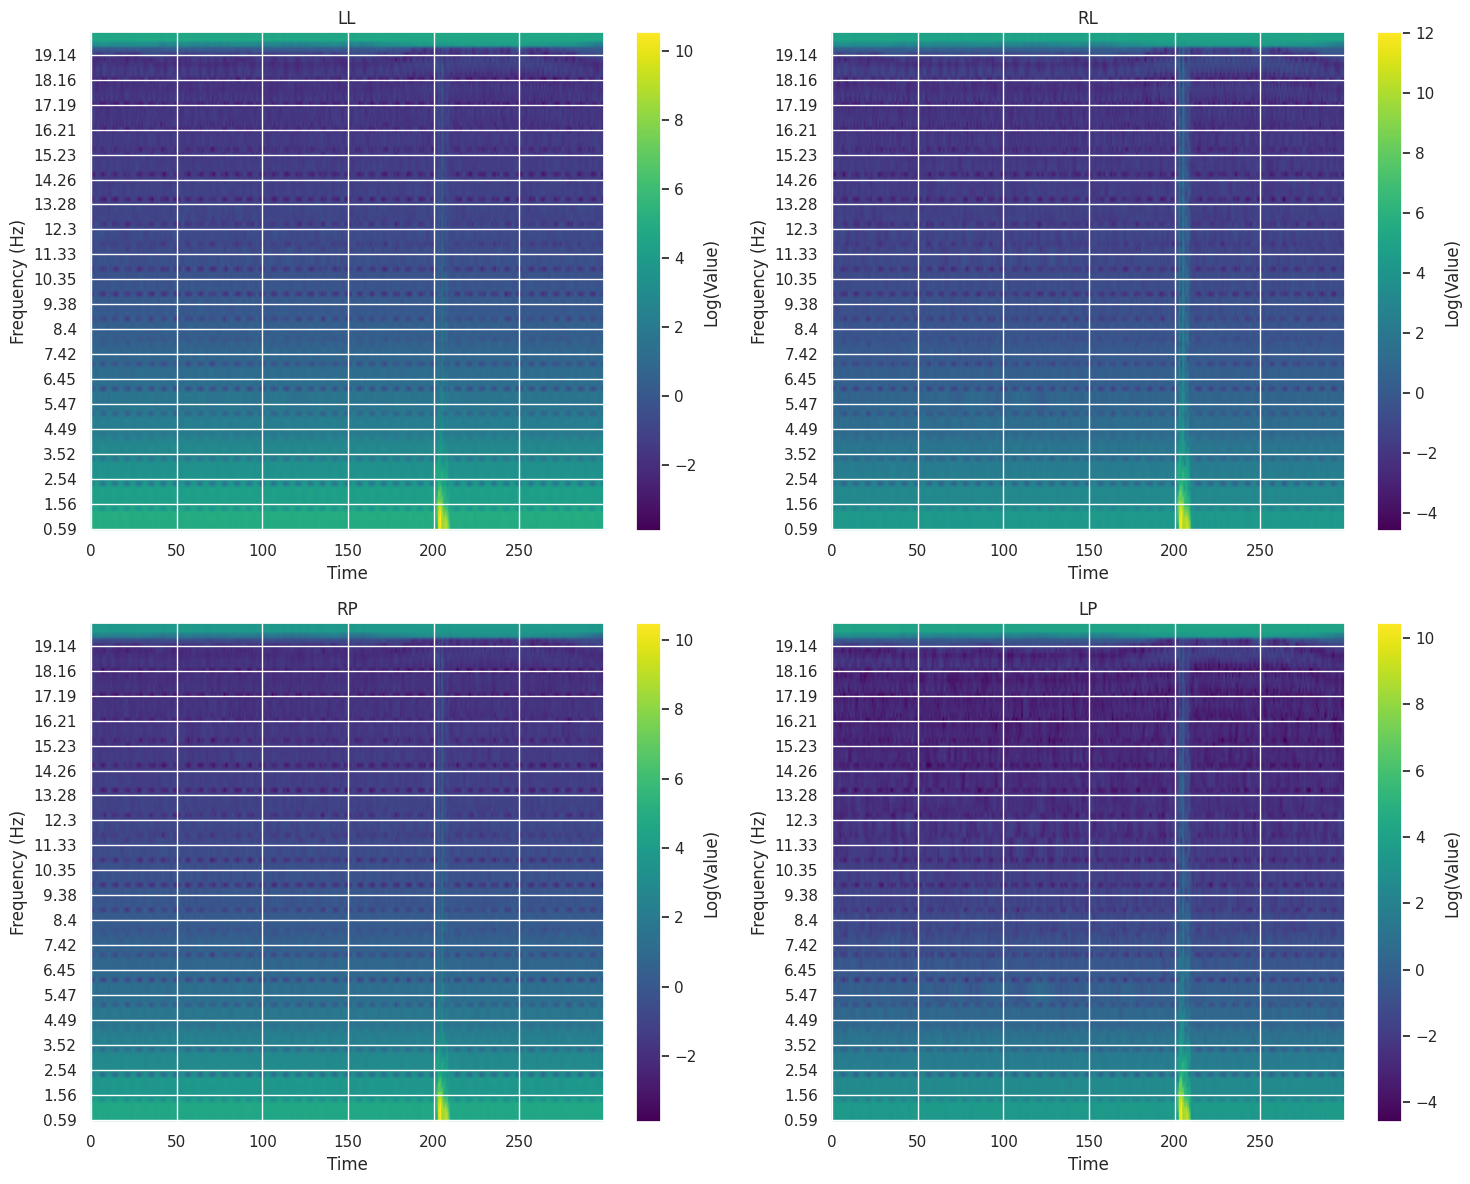

CPU times: user 6.05 s, sys: 6.27 s, total: 12.3 s
Wall time: 1min 4s


In [19]:
%%time
READ_SPEC_FILES = False

paths_spectograms = glob(paths.TRAIN_SPECTOGRAMS + "*.parquet")
print(f'There are {len(paths_spectograms)} spectrogram parquets')

if READ_SPEC_FILES:    
    all_spectrograms = {}
    for file_path in tqdm(paths_spectograms):
        aux = pd.read_parquet(file_path)
        name = int(file_path.split("/")[-1].split('.')[0])
        all_spectrograms[name] = aux.iloc[:,1:].values
        del aux
else:
    all_spectrograms = np.load(paths.PRE_LOADED_SPECTOGRAMS, allow_pickle=True).item()
    
if config.VISUALIZE:
    idx = np.random.randint(0,len(paths_spectograms))
    spectrogram_path = paths_spectograms[idx]
    plot_spectrogram(spectrogram_path)

### <b><span style='color:#F1A424'>Read EEG Spectrograms</span></b>

The resulting `all_eegs` dictionary contains `eeg_id` as keys (`int` keys) and the values are the eeg sequences (as 3-dimensional `np.array`) of shape `(128, 256, 4)`.



In [20]:
%%time
READ_EEG_SPEC_FILES = False

paths_eegs = glob(paths.TRAIN_EEGS + "*.npy")
print(f'There are {len(paths_eegs)} EEG spectograms')

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for file_path in tqdm(paths_eegs):
        eeg_id = file_path.split("/")[-1].split(".")[0]
        eeg_spectogram = np.load(file_path)
        all_eegs[eeg_id] = eeg_spectogram
else:
    all_eegs = np.load(paths.PRE_LOADED_EEGS, allow_pickle=True).item()

There are 17089 EEG spectograms
CPU times: user 4.14 s, sys: 7.89 s, total: 12 s
Wall time: 1min 11s


In [21]:
### ADDED (from discussion: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-60?scriptVersionId=159895287)

%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'

# FEATURE NAMES
SPEC_COLS = pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
FEATURES += [f'eeg_mean_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_min_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_max_f{x}_10s' for x in range(512)]
FEATURES += [f'eeg_std_f{x}_10s' for x in range(512)]
print(f'We are creating {len(FEATURES)} features for {len(train_df)} rows... ',end='')

data = np.zeros((len(train_df),len(FEATURES)))
for k in range(len(train_df)):
    if k%100==0: print(k,', ',end='')
    row = train_df.iloc[k]
    r = int( (row['min'] + row['max'])//4 ) 

    # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
    x = np.nanmean(all_spectrograms[row.spectogram_id][r:r+300,:],axis=0)
    data[k,:400] = x
    x = np.nanmin(all_spectrograms[row.spectogram_id][r:r+300,:],axis=0)
    data[k,400:800] = x

    # 20 SECOND WINDOW FEATURES (MEANS and MINS)
    x = np.nanmean(all_spectrograms[row.spectogram_id][r+145:r+155,:],axis=0)
    data[k,800:1200] = x
    x = np.nanmin(all_spectrograms[row.spectogram_id][r+145:r+155,:],axis=0)
    data[k,1200:1600] = x



    # RESHAPE EEG SPECTROGRAMS 128x256x4 => 512x256
    eeg_spec = np.zeros((512,256),dtype='float32')
    xx = all_eegs[row.eeg_id]
    for j in range(4): eeg_spec[128*j:128*(j+1),] = xx[:,:,j]

    # 10 SECOND WINDOW FROM EEG SPECTROGRAMS 
    x = np.nanmean(eeg_spec.T[100:-100,:],axis=0)
    data[k,1600:2112] = x
    x = np.nanmin(eeg_spec.T[100:-100,:],axis=0)
    data[k,2112:2624] = x
    x = np.nanmax(eeg_spec.T[100:-100,:],axis=0)
    data[k,2624:3136] = x
    x = np.nanstd(eeg_spec.T[100:-100,:],axis=0)
    data[k,3136:3648] = x

train_df[FEATURES] = data
print(); print('New train shape:',train_df.shape)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
We are creating 3648 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 1240

In [22]:
### ADDED: Train CatBoost (https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-60?scriptVersionId=159895287)

import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.2


In [23]:
### ADDED: Train CatBoost (https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-60?scriptVersionId=159895287)
from sklearn.model_selection import KFold, GroupKFold

all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train_df, train_df.target, train_df.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    model = CatBoostClassifier(task_type='GPU', # change CPU
                               loss_function='MultiClass')
    
    train_pool = Pool(
        data = train_df.loc[train_index,FEATURES],
        label = train_df.loc[train_index,'target'].map(TARS),
    )
    
    valid_pool = Pool(
        data = train_df.loc[valid_index,FEATURES],
        label = train_df.loc[valid_index,'target'].map(TARS),
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )
    model.save_model(f'CAT_v_1_f{i}.cat')
    
    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(train_df.loc[valid_index, label_cols].values)
    
    del train_pool, valid_pool, oof #model
    gc.collect()
    
    #break
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Learning rate set to 0.136945
0:	learn: 1.6426884	test: 1.6701102	best: 1.6701102 (0)	total: 358ms	remaining: 5m 57s
100:	learn: 0.7130797	test: 1.0630036	best: 1.0621469 (98)	total: 8.94s	remaining: 1m 19s
200:	learn: 0.5675648	test: 1.0286191	best: 1.0284629 (190)	total: 17.7s	remaining: 1m 10s
300:	learn: 0.4650768	test: 1.0160923	best: 1.0153919 (288)	total: 25.9s	remaining: 1m
400:	learn: 0.3877164	test: 1.0115105	best: 1.0102535 (381)	total: 34.2s	remaining: 51.1s
500:	learn: 0.3292166	test: 1.0079141	best: 1.0045746 (460)	total: 42.3s	remaining: 42.1s
600:	learn: 0.2807280	test: 1.0097705	best: 1.0045746 (460)	total: 50.8s	remaining: 33.7s
700:	learn: 0.2430460	test: 1.0105180	best: 1.0045746 (460)	total: 59s	remaining: 25.2s
800:	learn: 0.2113588	test: 1.0114972	best: 1.0045746 (460)	total: 1m 7s	remaining: 16.8s
900:	learn: 0.1849249	test: 1.0200345	best: 1.0045746 (460)	total:

In [24]:
### CV Score for CatBoost (https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-60?scriptVersionId=159895287)

import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

CV Score KL-Div for CatBoost = 0.7437771430112271
